In [1]:
!pip install seaborn

In [2]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import itertools
import time
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Twelve Data API configuration
API_KEY = "YOUR_API_KEY_HERE"  # Replace with your actual API key
symbol = "NVDA"
url = "https://api.twelvedata.com/time_series"
# API parameters for daily price data (~4 years)
params = {
    "symbol": symbol,
    "interval": "1day",
    "outputsize": 1000,
    "apikey": API_KEY
}
print("Fetching NVDA historical data from Twelve Data API...")
print(f"Endpoint: {url}")
print(f"Symbol: {symbol}\n")
try:
    # Send GET request
    response = requests.get(url, params=params, timeout=10)
    response.raise_for_status()  # Raise exception for bad status codes
    
    # Parse JSON response
    data = response.json()
    
    # Check for API errors
    if "error" in data:
        raise ValueError(f"API error: {data['error']}")
    
    if "values" not in data:
        raise ValueError("No 'values' in response. API may have rate limited or changed.")
    
    print(f"✓ Successfully retrieved {len(data['values'])} records\n")

except requests.exceptions.RequestException as e:
    print(f"✗ API request failed: {e}")
    print("Attempting fallback: Loading from local CSV if available...\n")
    try:
        nvda_raw = pd.read_csv('nvda_3y.csv', index_col=0, parse_dates=True)
        print("✓ Loaded from local CSV")
    except FileNotFoundError:
        print("✗ No local CSV file found. Please check API key and connection.")
        raise

Fetching NVDA historical data from Twelve Data API...
Endpoint: https://api.twelvedata.com/time_series
Symbol: NVDA

✓ Successfully retrieved 1000 records



## Data Preprocessing

In [4]:
# Convert JSON to DataFrame
nvda_raw = pd.DataFrame(data["values"])
print("Raw data shape:", nvda_raw.shape)
print("\nFirst few rows:")
print(nvda_raw.head())
print("\nData types before conversion:")
print(nvda_raw.dtypes)

Raw data shape: (1000, 6)

First few rows:
     datetime       open       high        low      close     volume
0  2026-01-28     191.24    192.335    189.845     191.74    9714225
1  2026-01-27  187.24001        190  185.70000  188.52000  143233500
2  2026-01-26  187.16000  189.12000  185.99001  186.47000  124799600
3  2026-01-23      187.5  189.60001  186.82001  187.67000  142748100
4  2026-01-22     184.75  186.17000  183.92999  184.84000  139636600

Data types before conversion:
datetime    str
open        str
high        str
low         str
close       str
volume      str
dtype: object


In [5]:
# Data cleaning and type conversion
print("\nCleaning and preprocessing data...\n")
# Convert datetime to pandas datetime format
nvda_raw["datetime"] = pd.to_datetime(nvda_raw["datetime"])
# Set datetime as index
nvda_raw.set_index("datetime", inplace=True)
# Convert price and volume columns to numeric
numeric_columns = ['open', 'high', 'low', 'close', 'volume']
for col in numeric_columns:
    if col in nvda_raw.columns:
        nvda_raw[col] = pd.to_numeric(nvda_raw[col], errors='coerce')
# Sort chronologically (oldest to newest)
nvda_raw.sort_index(inplace=True)
# Check for missing values
print(f"Missing values:\n{nvda_raw.isna().sum()}\n")
# Remove any rows with NaN values
nvda_raw.dropna(inplace=True)
print(f"Final raw dataset shape: {nvda_raw.shape}")
print(f"Date range: {nvda_raw.index.min()} to {nvda_raw.index.max()}")
print(f"\nData info after cleaning:")
print(nvda_raw.info())


Cleaning and preprocessing data...

Missing values:
open      0
high      0
low       0
close     0
volume    0
dtype: int64

Final raw dataset shape: (1000, 5)
Date range: 2022-02-02 00:00:00 to 2026-01-28 00:00:00

Data info after cleaning:
<class 'pandas.DataFrame'>
DatetimeIndex: 1000 entries, 2022-02-02 to 2026-01-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1000 non-null   float64
 1   high    1000 non-null   float64
 2   low     1000 non-null   float64
 3   close   1000 non-null   float64
 4   volume  1000 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 46.9 KB
None


## Filter to last 3 years

In [ ]:
# Filter to last 3 years
three_years_ago = datetime.now() - timedelta(days=365 * 3)
nvda_3y = nvda_raw[nvda_raw.index >= three_years_ago].copy()
print(f"Dataset filtered to last 3 years")
print(f"Records: {len(nvda_3y)} trading days")
print(f"Date range: {nvda_3y.index.min().date()} to {nvda_3y.index.max().date()}")
print(f"\nSummary statistics:\n{nvda_3y.describe()}")
# Save to CSV for reproducibility
nvda_3y.to_csv("nvda_3y.csv")
print("\n✓ Saved to nvda_3y.csv")

Dataset filtered to last 3 years
Records: 752 trading days
Date range: 2023-01-30 to 2026-01-28

Summary statistics:
             open        high         low       close        volume
count  752.000000  752.000000  752.000000  752.000000  7.520000e+02
mean   103.538338  105.201282  101.650660  103.502918  3.497392e+08
std     54.005664   54.636688   53.143624   53.879118  1.780656e+08
min     19.170000   19.687000   18.950000   19.162000  9.714225e+06
25%     46.648250   47.393000   45.933500   46.761250  2.066262e+08
50%    111.980000  114.939500  109.366500  111.600000  3.239048e+08
75%    141.975003  143.452503  138.847498  140.927500  4.465092e+08
max    208.080002  212.190000  205.560000  207.039993  1.543911e+09

✓ Saved to nvda_3y.csv


## Exploratory data analysis (EDA)

#### Close Price Trend

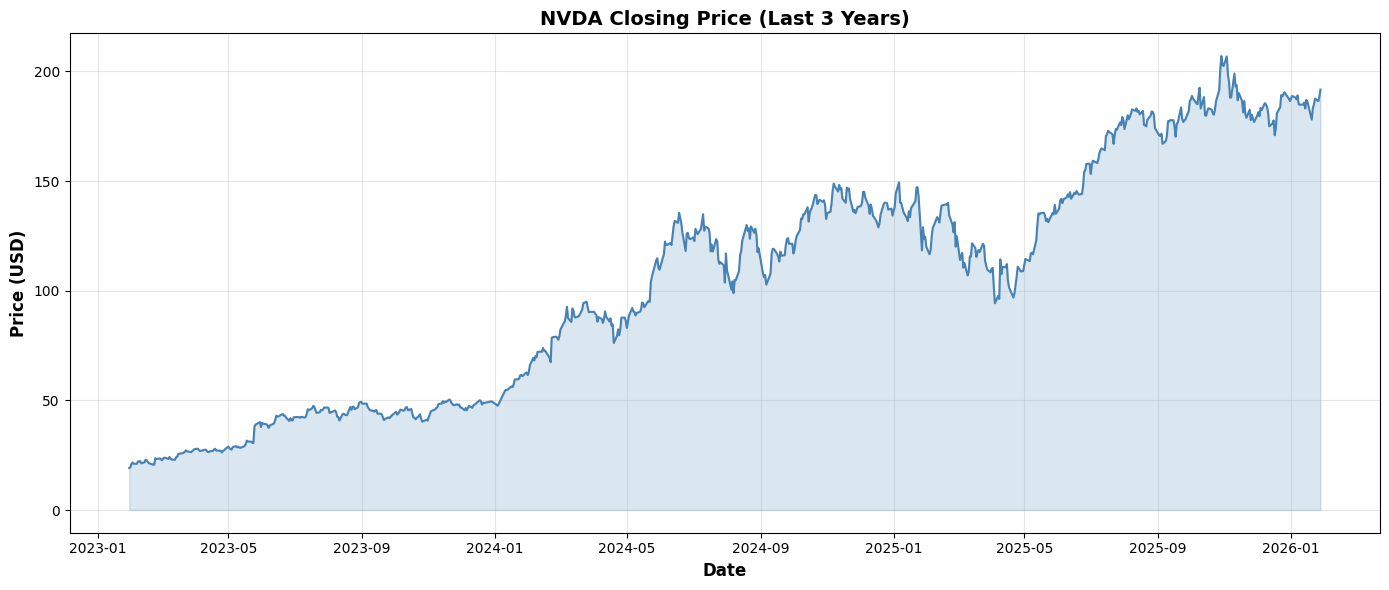

Price Statistics:
  Minimum: $19.16
  Maximum: $207.04
  Mean:    $103.50
  Std Dev: $53.88


In [7]:
# Plot closing price over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(nvda_3y.index, nvda_3y['close'], linewidth=1.5, color='steelblue', label='Closing Price')
ax.fill_between(nvda_3y.index, nvda_3y['close'], alpha=0.2, color='steelblue')
ax.set_title('NVDA Closing Price (Last 3 Years)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Print statistics
print(f"Price Statistics:")
print(f"  Minimum: ${nvda_3y['close'].min():.2f}")
print(f"  Maximum: ${nvda_3y['close'].max():.2f}")
print(f"  Mean:    ${nvda_3y['close'].mean():.2f}")
print(f"  Std Dev: ${nvda_3y['close'].std():.2f}")

#### Trading Volume

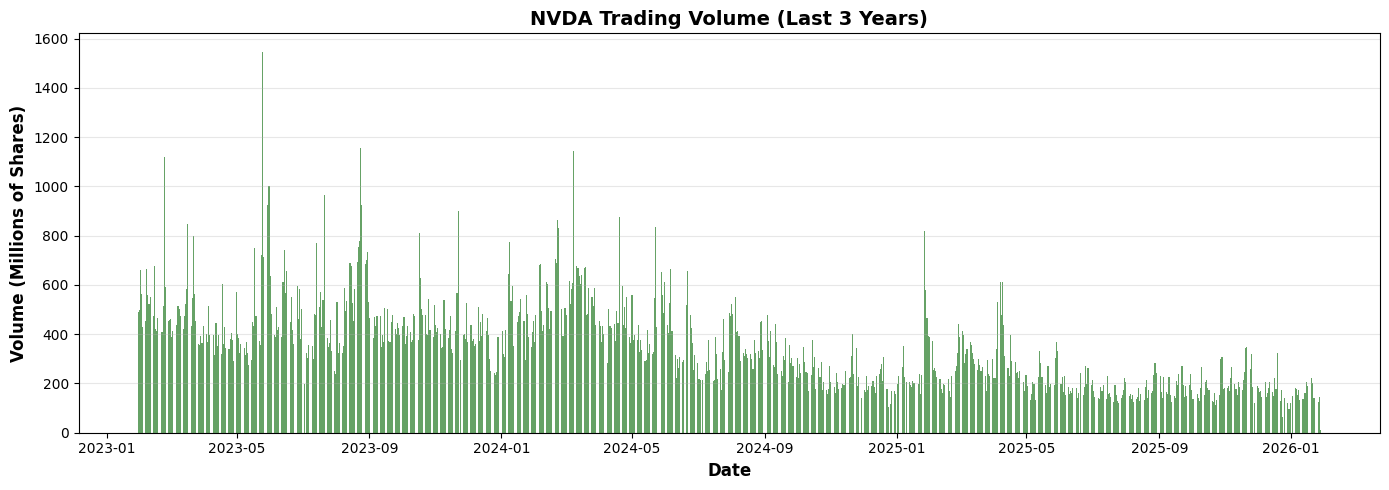

Volume Statistics:
  Mean Daily Volume: 349.74M shares
  Median Daily Volume: 323.90M shares


In [8]:
# Plot trading volume
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(nvda_3y.index, nvda_3y['volume'] / 1e6, color='darkgreen', alpha=0.6, width=1)
ax.set_title('NVDA Trading Volume (Last 3 Years)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Volume (Millions of Shares)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print(f"Volume Statistics:")
print(f"  Mean Daily Volume: {nvda_3y['volume'].mean() / 1e6:.2f}M shares")
print(f"  Median Daily Volume: {nvda_3y['volume'].median() / 1e6:.2f}M shares")

#### Daily Return Distribution

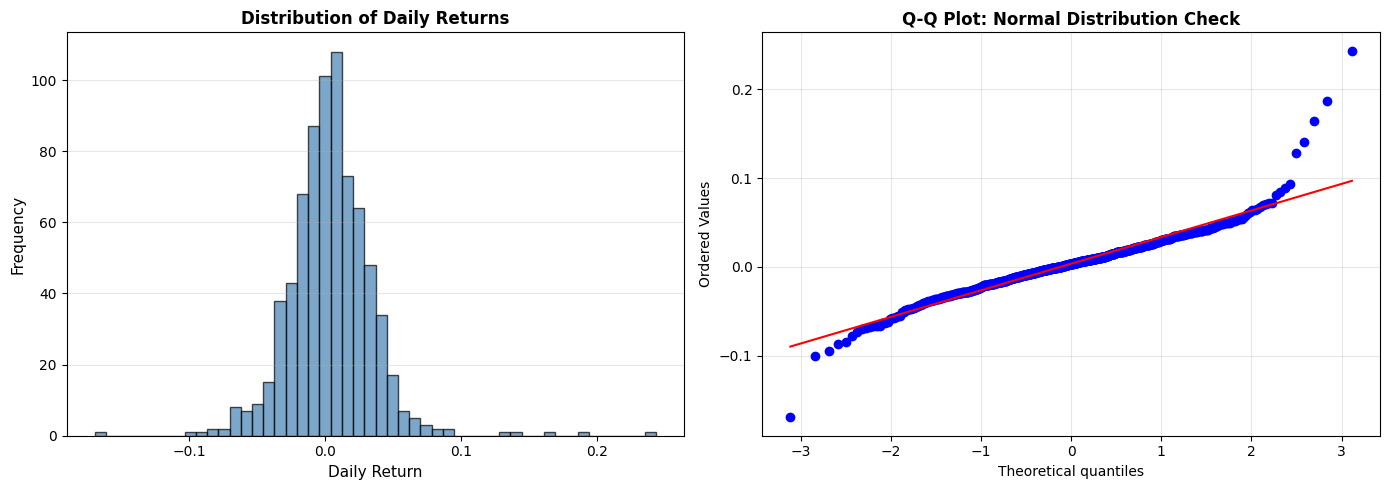

In [9]:
# Calculate daily returns
nvda_3y['daily_return'] = nvda_3y['close'].pct_change()
# Plot distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.hist(nvda_3y['daily_return'].dropna(), bins=50, color='steelblue', 
        edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Daily Returns', fontsize=12, fontweight='bold')
ax1.set_xlabel('Daily Return', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
# Q-Q plot for normality check
from scipy import stats
stats.probplot(nvda_3y['daily_return'].dropna(), dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot: Normal Distribution Check', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Moving average and volatility

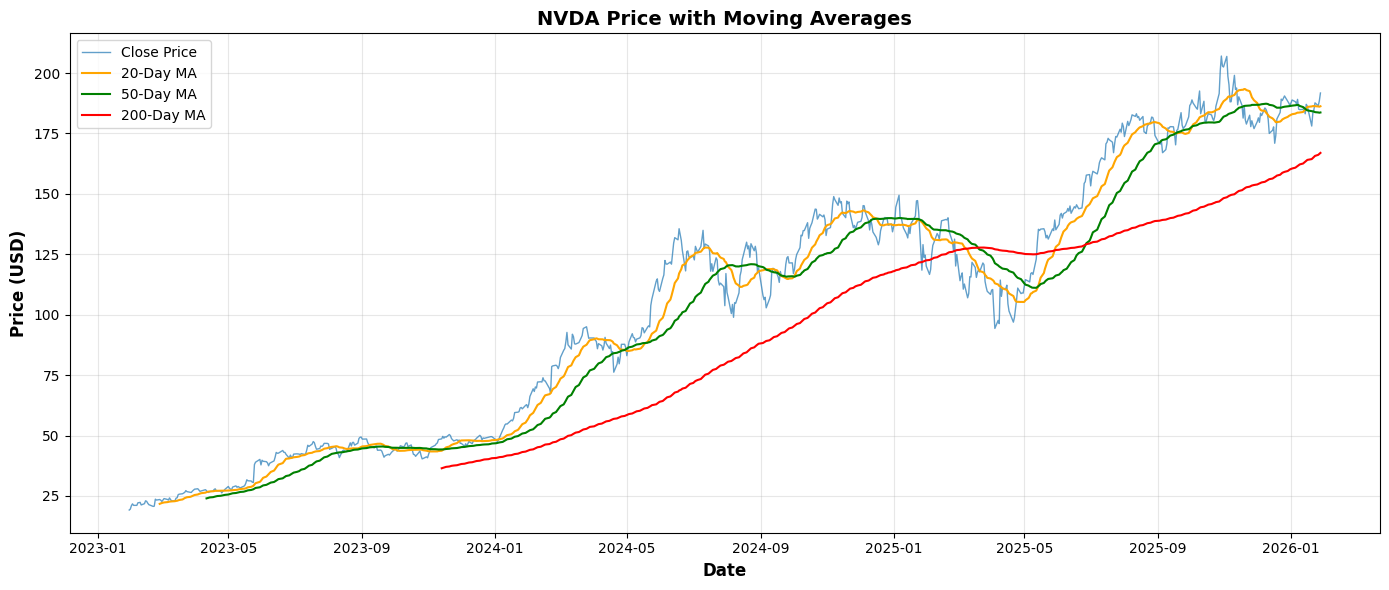

In [10]:
# Calculate moving averages
nvda_3y['MA_20'] = nvda_3y['close'].rolling(window=20).mean()
nvda_3y['MA_50'] = nvda_3y['close'].rolling(window=50).mean()
nvda_3y['MA_200'] = nvda_3y['close'].rolling(window=200).mean()
# Plot with moving averages
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(nvda_3y.index, nvda_3y['close'], linewidth=1, label='Close Price', alpha=0.7)
ax.plot(nvda_3y.index, nvda_3y['MA_20'], linewidth=1.5, label='20-Day MA', color='orange')
ax.plot(nvda_3y.index, nvda_3y['MA_50'], linewidth=1.5, label='50-Day MA', color='green')
ax.plot(nvda_3y.index, nvda_3y['MA_200'], linewidth=1.5, label='200-Day MA', color='red')
ax.set_title('NVDA Price with Moving Averages', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Rolling volatility

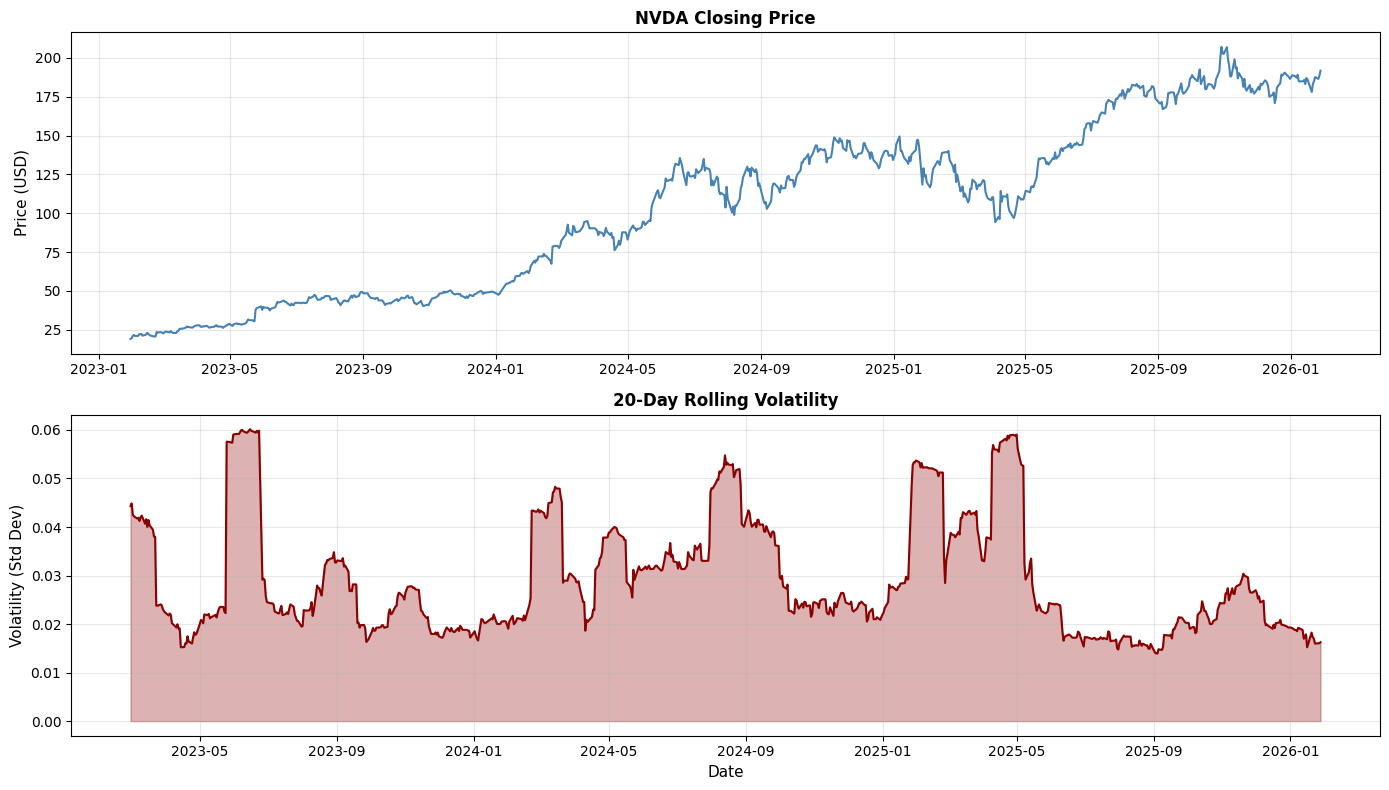

Volatility Statistics (20-day rolling):
  Mean:     0.0291
  Min:      0.0139
  Max:      0.0602


In [11]:
# Calculate rolling volatility (20-day window)
nvda_3y['volatility'] = nvda_3y['daily_return'].rolling(window=20).std()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
# Price
ax1.plot(nvda_3y.index, nvda_3y['close'], linewidth=1.5, color='steelblue')
ax1.set_title('NVDA Closing Price', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price (USD)', fontsize=11)
ax1.grid(True, alpha=0.3)
# Volatility
ax2.plot(nvda_3y.index, nvda_3y['volatility'], linewidth=1.5, color='darkred')
ax2.fill_between(nvda_3y.index, nvda_3y['volatility'], alpha=0.3, color='darkred')
ax2.set_title('20-Day Rolling Volatility', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Volatility (Std Dev)', fontsize=11)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Volatility Statistics (20-day rolling):")
print(f"  Mean:     {nvda_3y['volatility'].mean():.4f}")
print(f"  Min:      {nvda_3y['volatility'].min():.4f}")
print(f"  Max:      {nvda_3y['volatility'].max():.4f}")

## Feature Engineering and Data Prep for LSTM

#### Extract and normalise closing price

In [12]:
# Extract closing prices
close_prices = nvda_3y[['close']].values
print(f"Closing prices shape: {close_prices.shape}")
print(f"Price range: ${close_prices.min():.2f} - ${close_prices.max():.2f}")
# Normalise to [0, 1] for LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)
print(f"\nScaled data range: {scaled_close.min():.4f} - {scaled_close.max():.4f}")
print(f"Scaler parameters: scale={scaler.scale_[0]:.6f}, min={scaler.data_min_[0]:.2f}")

Closing prices shape: (752, 1)
Price range: $19.16 - $207.04

Scaled data range: 0.0000 - 1.0000
Scaler parameters: scale=0.005323, min=19.16


#### Create Sequences for LSTM

In [13]:
def create_sequences(data, window_size):
    """
    Create sequences for LSTM training.
    
    Args:
        data: 1D array of scaled prices
        window_size: Number of timesteps in each sequence
    
    Returns:
        X: Array of shape (n_samples, window_size, 1)
        y: Array of shape (n_samples,)
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)
# Create sequences with 30-day window
WINDOW_SIZE = 30
X, y = create_sequences(scaled_close, WINDOW_SIZE)
print(f"Sequences created with window size: {WINDOW_SIZE}")
print(f"X shape: {X.shape} (samples, timesteps, features)")
print(f"y shape: {y.shape}")
print(f"\nTotal sequences: {len(X)}")
print(f"Sample X[0] shape: {X[0].shape}")
print(f"Sample y[0]: {y[0][0]:.4f}")


Sequences created with window size: 30
X shape: (722, 30, 1) (samples, timesteps, features)
y shape: (722, 1)

Total sequences: 722
Sample X[0] shape: (30, 1)
Sample y[0]: 0.0261


#### Train Test Split

In [14]:
# Chronological split to preserve temporal order
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]
print(f"Train-Test Split (80-20):")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples:  {len(X_test)}")
print(f"  Total:            {len(X_train) + len(X_test)}")
print(f"\nTraining data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape:  X_test={X_test.shape}, y_test={y_test.shape}")

Train-Test Split (80-20):
  Training samples: 577
  Testing samples:  145
  Total:            722

Training data shape: X_train=(577, 30, 1), y_train=(577, 1)
Testing data shape:  X_test=(145, 30, 1), y_test=(145, 1)


## Baseline LSTM model

#### Building the baseline model

In [15]:
# Build baseline LSTM model
baseline_model = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
# Compile model
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)
print("Baseline LSTM Model Architecture:")
baseline_model.summary()

Baseline LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

#### Train baseline model

In [16]:
print("Training baseline model...\n")
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
print("\n✓ Baseline model training completed")

Training baseline model...

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - loss: 0.0451 - val_loss: 0.0582
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0070 - val_loss: 0.0090
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━

## Model evaluation

In [17]:
baseline_predictions = baseline_model.predict(X_test, verbose=0)

# Ensure 2D
if baseline_predictions.ndim == 1:
    baseline_predictions = baseline_predictions.reshape(-1, 1)
if y_test.ndim == 1:
    y_test = y_test.reshape(-1, 1)

baseline_pred_actual = scaler.inverse_transform(baseline_predictions) 
y_test_actual = scaler.inverse_transform(y_test)                       
# Calculate metrics
baseline_mape = mean_absolute_percentage_error(y_test_actual, baseline_pred_actual)
baseline_rmse = np.sqrt(mean_squared_error(y_test_actual, baseline_pred_actual))
baseline_r2 = r2_score(y_test_actual, baseline_pred_actual)
baseline_mae = np.mean(np.abs(y_test_actual - baseline_pred_actual))
print("="*70)
print("BASELINE MODEL EVALUATION")
print("="*70)
print(f"R² Score:  {baseline_r2:>10.6f}")
print(f"MAPE:      {baseline_mape:>10.6f}%")
print(f"RMSE:      ${baseline_rmse:>9.2f}")
print(f"MAE:       ${baseline_mae:>9.2f}")
print("="*70)

BASELINE MODEL EVALUATION
R² Score:   -1.029957
MAPE:        0.061669%
RMSE:      $    12.61
MAE:       $    11.29


#### Baseline model evaluation

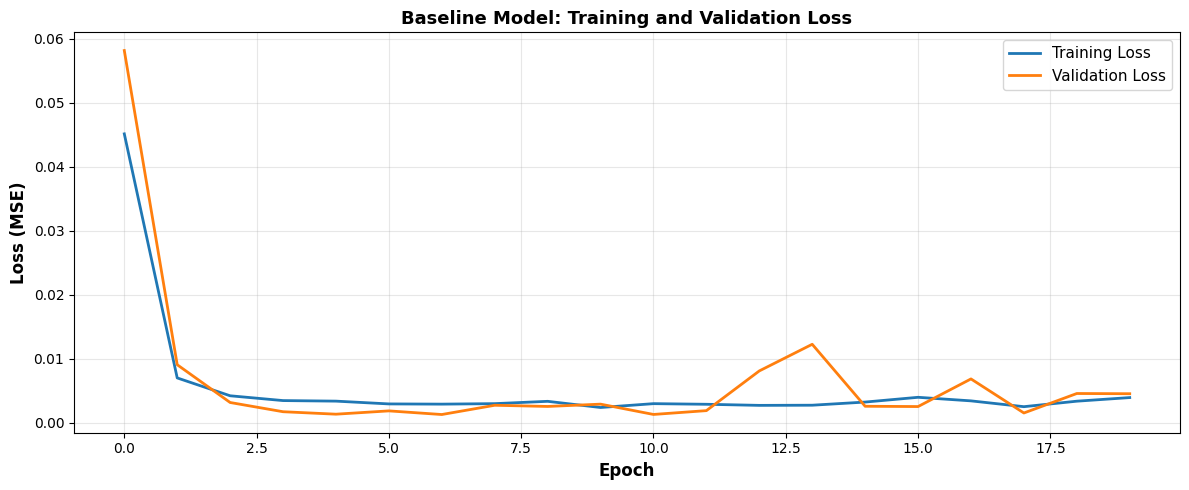

In [19]:
# Plot training history
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(baseline_history.history['loss'], label='Training Loss', linewidth=2)
ax.plot(baseline_history.history['val_loss'], label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
ax.set_title('Baseline Model: Training and Validation Loss', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

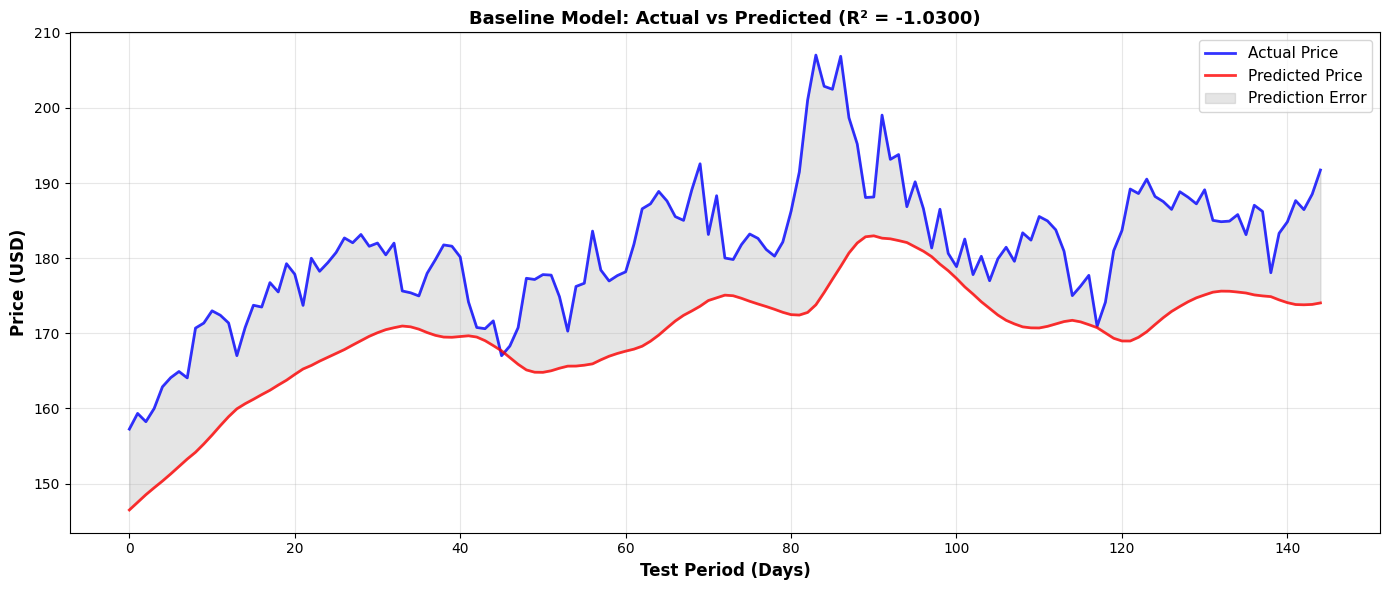

In [20]:
# Visualise predictions vs actual
fig, ax = plt.subplots(figsize=(14, 6))
time_steps = range(len(y_test_actual))
ax.plot(time_steps, y_test_actual, 'b-', linewidth=2, label='Actual Price', alpha=0.8)
ax.plot(time_steps, baseline_pred_actual, 'r-', linewidth=2, label='Predicted Price', alpha=0.8)
ax.fill_between(time_steps, y_test_actual.flatten(), baseline_pred_actual.flatten(),
                alpha=0.2, color='gray', label='Prediction Error')
ax.set_xlabel('Test Period (Days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=12, fontweight='bold')
ax.set_title(f'Baseline Model: Actual vs Predicted (R² = {baseline_r2:.4f})', 
            fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()